# Importing libraries

In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
import time
import random
import json
from scipy import stats

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from pandarallel import pandarallel
from tqdm import tqdm
from tqdm.notebook import tqdm
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import lxml
import importlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import FastText
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D


from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

from Bio import SeqUtils

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from IPython.core.display import display, HTML
pandarallel.initialize(progress_bar = True)
tqdm.pandas()

2023-01-28 17:31:07.883404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-28 17:31:07.883449: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_4896/594879619.py:65: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Helper functions

In [6]:
def dataframe_to_embed_array(interactions_df, drug_list, target_list, drug_embed_len = 300, debug = True):
    
    X_0_list = []
    X_1_list = []
    
    skipped_drugs = 0
    for idx, row in interactions_df.iterrows():

        drug = row['InChiKey']
        target = row['target_aa_code']

        try:
            drug_index = drug_list.index(drug)
        except: 
            drug_index = -1

        target_index = target_list.index(target)

        X_0_list.append(normalized_target_embeddings[target_index])
        if drug_index == -1:
            X_1_list.append(np.random.randn(drug_embed_len,))
            skipped_drugs = skipped_drugs + 1
        else:
            try:
                X_1_list.append(normalized_drug_embeddings[drug_index])
            except: 
                X_1_list.append(np.random.randn(drug_embed_len,))
                skipped_drugs = skipped_drugs + 1
                
    X_0 = np.array(X_0_list)
    X_1 = np.array(X_1_list)
    Y   = np.array(list(interactions_df['Y']))
    
    if debug:
        print ("Number of drugs skipped : ", skipped_drugs)
    
    return X_0, X_1, Y

In [7]:
def get_interaction_splits(positive_interactions, targets, frac = 0.15):

    # Set Seed
    np.random.seed(2020)


    # Make Unseen Targets
    unseen_targets = np.random.choice(list(targets['Label']), size = int(frac * targets.shape[0]), replace = False)

    # Create dataframe with unseen targets 
    unseen_target_test = positive_interactions[positive_interactions['target_aa_code'].isin(unseen_targets)]

    # Create dataframe with unseen edges
    seen_target_df = pd.concat([positive_interactions, unseen_target_test]).drop_duplicates(keep = False)
    unseen_edges_test = seen_target_df.sample(frac = 0.15, replace = False)

    # Create dataframe with train interactions
    train_interactions = pd.concat([seen_target_df, unseen_edges_test]).drop_duplicates(keep = False)
    seen_targets = set(train_interactions['target_aa_code'])
    
    return unseen_targets, seen_targets, unseen_target_test, unseen_edges_test, train_interactions

In [8]:
def get_train_w_random_neg(train_interactions, seen_drugs, seen_targets, num_negatives, all_positives):

    train_w_random_neg = []
    num_negatives = 8

    # Shuffle Train Interactions
    train_interactions = train_interactions.sample(frac = 1, replace = False)

    # For each positive interaction
    for idx, row in tqdm(train_interactions.iterrows()):

        # Drop extra drug or target?
        drop_negative_drug = np.random.randint(2)

        # Add existing positive to final train
        positive_example = [row['InChiKey'], row['target_aa_code'], 1]
        train_w_random_neg.append(positive_example)

        # Random Negative Drugs
        pos_drugs = set(all_positives[all_positives['target_aa_code'] == row['target_aa_code']]['InChiKey'].tolist())
        drug_pool = list(set(seen_drugs).difference(pos_drugs))
        random_negative_drugs = random.sample(drug_pool, num_negatives - drop_negative_drug) 
        for i in random_negative_drugs:
            negative_example = [i, row['target_aa_code'], 0]
            train_w_random_neg.append(negative_example)

        # Random Negative Targets
        pos_targets = set(all_positives[all_positives['InChiKey'] == row['InChiKey']]['target_aa_code'].tolist())
        target_pool = list(set(seen_targets).difference(pos_targets))
        random_negative_targets = random.sample(target_pool, num_negatives - (1 - drop_negative_drug))
        for j in random_negative_targets:
            negative_example = [row['InChiKey'], j, 0]
            train_w_random_neg.append(negative_example)

    train_w_random_neg = pd.DataFrame(train_w_random_neg)
    train_w_random_neg.columns = ['InChiKey', 'target_aa_code', 'Y']

    return train_w_random_neg

In [9]:
def epoch_name(i):
    epoch_num = i//3
    idx_num = round((i/4 - epoch_num)*1000)
    return  "epoch_" + str(epoch_num) + '_idx_' + str(idx_num) + ".model"

In [10]:
def epoch_name(i):
    epoch_num = i // 3
    indices = [0, 250, 500]
    idx_num = indices[i % 3]
    return  "epoch_" + str(epoch_num) + '_idx_' + str(idx_num) + ".model"

In [11]:
def log_binning_distribution(x_i,B = 20): 

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    b_list.append(b_Bp1)
    
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

In [12]:
def remove_zeros(x_i,k_i):
    for i in range(len(x_i)):
        if x_i[i] == 0:
            x_i.pop(x_i[i])
            k_i.pop(k_i[i])
    return x_i, k_i

In [13]:
def log_binning_function(x_i,k_i,B = 20):  # Default number of bins is 20
    
    x_i,k_i = remove_zeros(x_i,k_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    # b_list.append(b_Bp1)
    
    binned_x_i = []
    binned_k_i = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        indices = []
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                indices.append(j)
        if not indices:
            continue
            # binned_k_i.append(float('nan'))
        else:
            bin_y_average = sum([k_i[index] for index in indices]) / len(indices)
            binned_k_i.append(bin_y_average)
            binned_x_i.append(bin_low)
            
    return binned_x_i, binned_k_i

# Loading datasets

In [14]:
with open('/data/sars-busters/Mol2Vec/chemicals_01_w_embed.pkl','rb') as file: 
    drugs = pkl.load(file)
    
with open('/data/sars-busters/Mol2Vec/amino_01_w_embed.pkl','rb') as file: 
    targets = pkl.load(file)
    
drug_list = list(drugs['Label'])
target_list = list(targets['Label'])

In [15]:
positive_interactions = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_1.csv')

In [16]:
with open('/data/sars-busters-consolidated/interactions/targets_test.pkl', 'rb') as file: 
    targets_test = pkl.load(file)
    
with open('/data/sars-busters-consolidated/interactions/targets_validation.pkl', 'rb') as file: 
    targets_validation = pkl.load(file)
    
with open('/data/sars-busters-consolidated/interactions/edges_test.pkl', 'rb') as file: 
    edges_test = pkl.load(file)
    
with open('/data/sars-busters-consolidated/interactions/edges_validation.pkl', 'rb') as file: 
    edges_validation = pkl.load(file)

# Random negative samples

In [17]:
train_sets = []
train_w_random_negs = []

for i in tqdm(range(len(targets_test))):

    # Unseen Targets
    unseen_targets = list(set(targets_test[i]['target_aa_code'])) + list(set(targets_validation[i]['target_aa_code']))
    unseen_drugs = list(set(targets_test[i]['InChiKey'])) + list(set(targets_validation[i]['InChiKey']))
    
    # Seen Targets
    seen_targets = set(targets['Label']).difference(unseen_targets)
    seen_drugs = set(drugs['Label']).difference(unseen_drugs)

    # Seen Targets 
    seen_target_df = positive_interactions[positive_interactions['target_aa_code'].isin(seen_targets)]
    seen_target_df = seen_target_df[["InChiKey", "target_aa_code", "Y"]]
        
    # Create dataframe with train interactions
    train_interactions = pd.concat([seen_target_df,
                                    edges_test[i],
                                    edges_test[i],
                                    edges_validation[i],
                                    edges_validation[i]]).drop_duplicates(keep = False)
    
    # Ensure Unseen Drugs
    train_interactions = train_interactions.reset_index(drop = True)
    drop_index = []
    for idx, row in tqdm(train_interactions.iterrows()):
        if row['InChiKey'] in unseen_drugs:
            drop_index.append(idx)
    train_interactions.drop(train_interactions.index[drop_index], inplace = True)
    
    train_sets.append(train_interactions)
    
    train_full = get_train_w_random_neg(train_interactions, seen_drugs, seen_targets, 8, positive_interactions)
    
    train_w_random_negs.append(train_full)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [18]:
for i in range(len(targets_test)):
    
    print ("Set : ", i)
    
    # No Overlap Between Unseen Targets and Train
    unseen_targets = list(set(targets_test[i]['target_aa_code'])) + list(set(targets_validation[i]['target_aa_code']))
    print ("Train - Test - Validation Overlap For Unseen Targets : ", len(list(set(train_sets[i]['target_aa_code']).intersection(unseen_targets))))
    
    # No overlap Between Drugs
    unseen_drugs = list(set(targets_test[i]['InChiKey'])) + list(set(targets_validation[i]['InChiKey']))
    print ("Train - Test - Validation Overlap For Unseen Drugs : ", len(list(set(train_sets[i]['InChiKey']).intersection(unseen_drugs))))


    # No Overlap Between Unseen Edges and Train
    train_edges = list(zip(list(train_sets[i]['InChiKey']), list(train_sets[i]['target_aa_code'])))
    temp_df = pd.concat([edges_test[i], edges_validation[i]])
    test_edges = list(zip(list(temp_df['InChiKey']), list(temp_df['target_aa_code'])))
    train_edges = set(train_edges)
    test_edges = set(test_edges)
    print ("Train - Test - Validation Overlap For Unseen Edges : ", len(list(train_edges.intersection(test_edges))))
    
    print ("Train Set : ", train_sets[i].shape)
    print ("Target Test : ", targets_test[i].shape)
    print ("Target Val : ", targets_validation[i].shape)
    print ("Edge Test : ", edges_test[i].shape)
    print ("Edge Val : ", edges_validation[i].shape)
    
    print ("")

Set :  0
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (6092, 3)
Target Test :  (5473, 3)
Target Val :  (5474, 3)
Edge Test :  (3843, 3)
Edge Val :  (3843, 3)

Set :  1
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (5112, 3)
Target Test :  (5755, 3)
Target Val :  (5755, 3)
Edge Test :  (3759, 3)
Edge Val :  (3759, 3)

Set :  2
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (6804, 3)
Target Test :  (5460, 3)
Target Val :  (5461, 3)
Edge Test :  (3847, 3)
Edge Val :  (3847, 3)

Set :  3
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unse

In [19]:
train = pd.concat([train_w_random_negs[0],train_w_random_negs[1],train_w_random_negs[2],train_w_random_negs[3],train_w_random_negs[4],train_w_random_negs[5]]) # .drop_duplicates(subset=['InChiKey','InChiKey'])

  0%|          | 0/7083 [00:00<?, ?it/s]

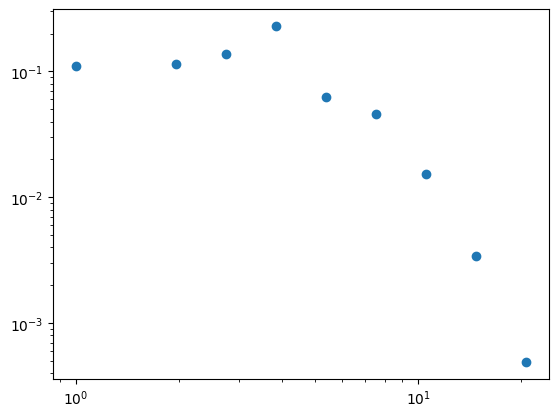

In [20]:
train_pos = train[train['Y'] == 1]

unique_ligands = set(train_pos['InChiKey'].tolist())

ligands_degree_dict = dict()

for ligand_name in tqdm(unique_ligands):
    subdf = train_pos[train_pos['InChiKey'] == ligand_name]
    ligands_degree_dict[ligand_name] = len(subdf)

binned_x_i, density_list = log_binning_distribution(list(ligands_degree_dict.values()),B = 10)
plt.loglog(binned_x_i,density_list,'o')

  0%|          | 0/7127 [00:00<?, ?it/s]

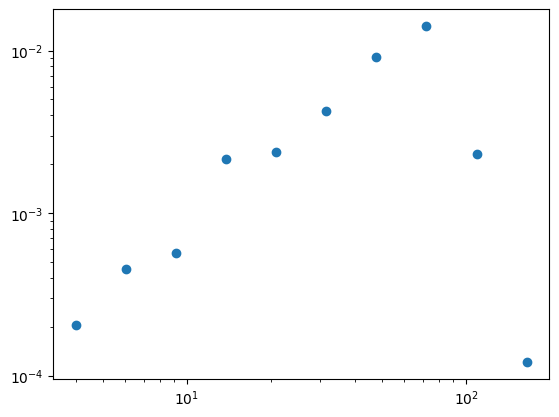

In [21]:
train_neg = train[train['Y'] == 0]

unique_ligands = set(train_neg['InChiKey'].tolist())

ligands_degree_dict = dict()

for ligand_name in tqdm(unique_ligands):
    subdf = train_neg[train_neg['InChiKey'] == ligand_name]
    ligands_degree_dict[ligand_name] = len(subdf)

binned_x_i, density_list = log_binning_distribution(list(ligands_degree_dict.values()),B = 10)
plt.loglog(binned_x_i,density_list,'o')

In [22]:
train_unique = pd.concat([train_w_random_negs[0],train_w_random_negs[1],train_w_random_negs[2],train_w_random_negs[3],train_w_random_negs[4],train_w_random_negs[5]]).drop_duplicates(subset=['InChiKey','target_aa_code'])

In [23]:
train_pos_unique = train_unique[train_unique['Y'] == 1]
train_neg_unique = train_unique[train_unique['Y'] == 0]

unique_ligands = set(train_unique['InChiKey'].tolist())

pos_deg_list_unique = []
neg_deg_list_unique = []

for ligand_name in tqdm(unique_ligands):
    subdf_pos_unique = train_pos_unique[train_pos_unique['InChiKey'] == ligand_name]
    pos_deg_list_unique.append(len(subdf_pos_unique))
    subdf_neg_unique = train_neg_unique[train_neg_unique['InChiKey'] == ligand_name]
    neg_deg_list_unique.append(len(subdf_neg_unique))


  0%|          | 0/7127 [00:00<?, ?it/s]

/tmp/ipykernel_4896/584291756.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,30])


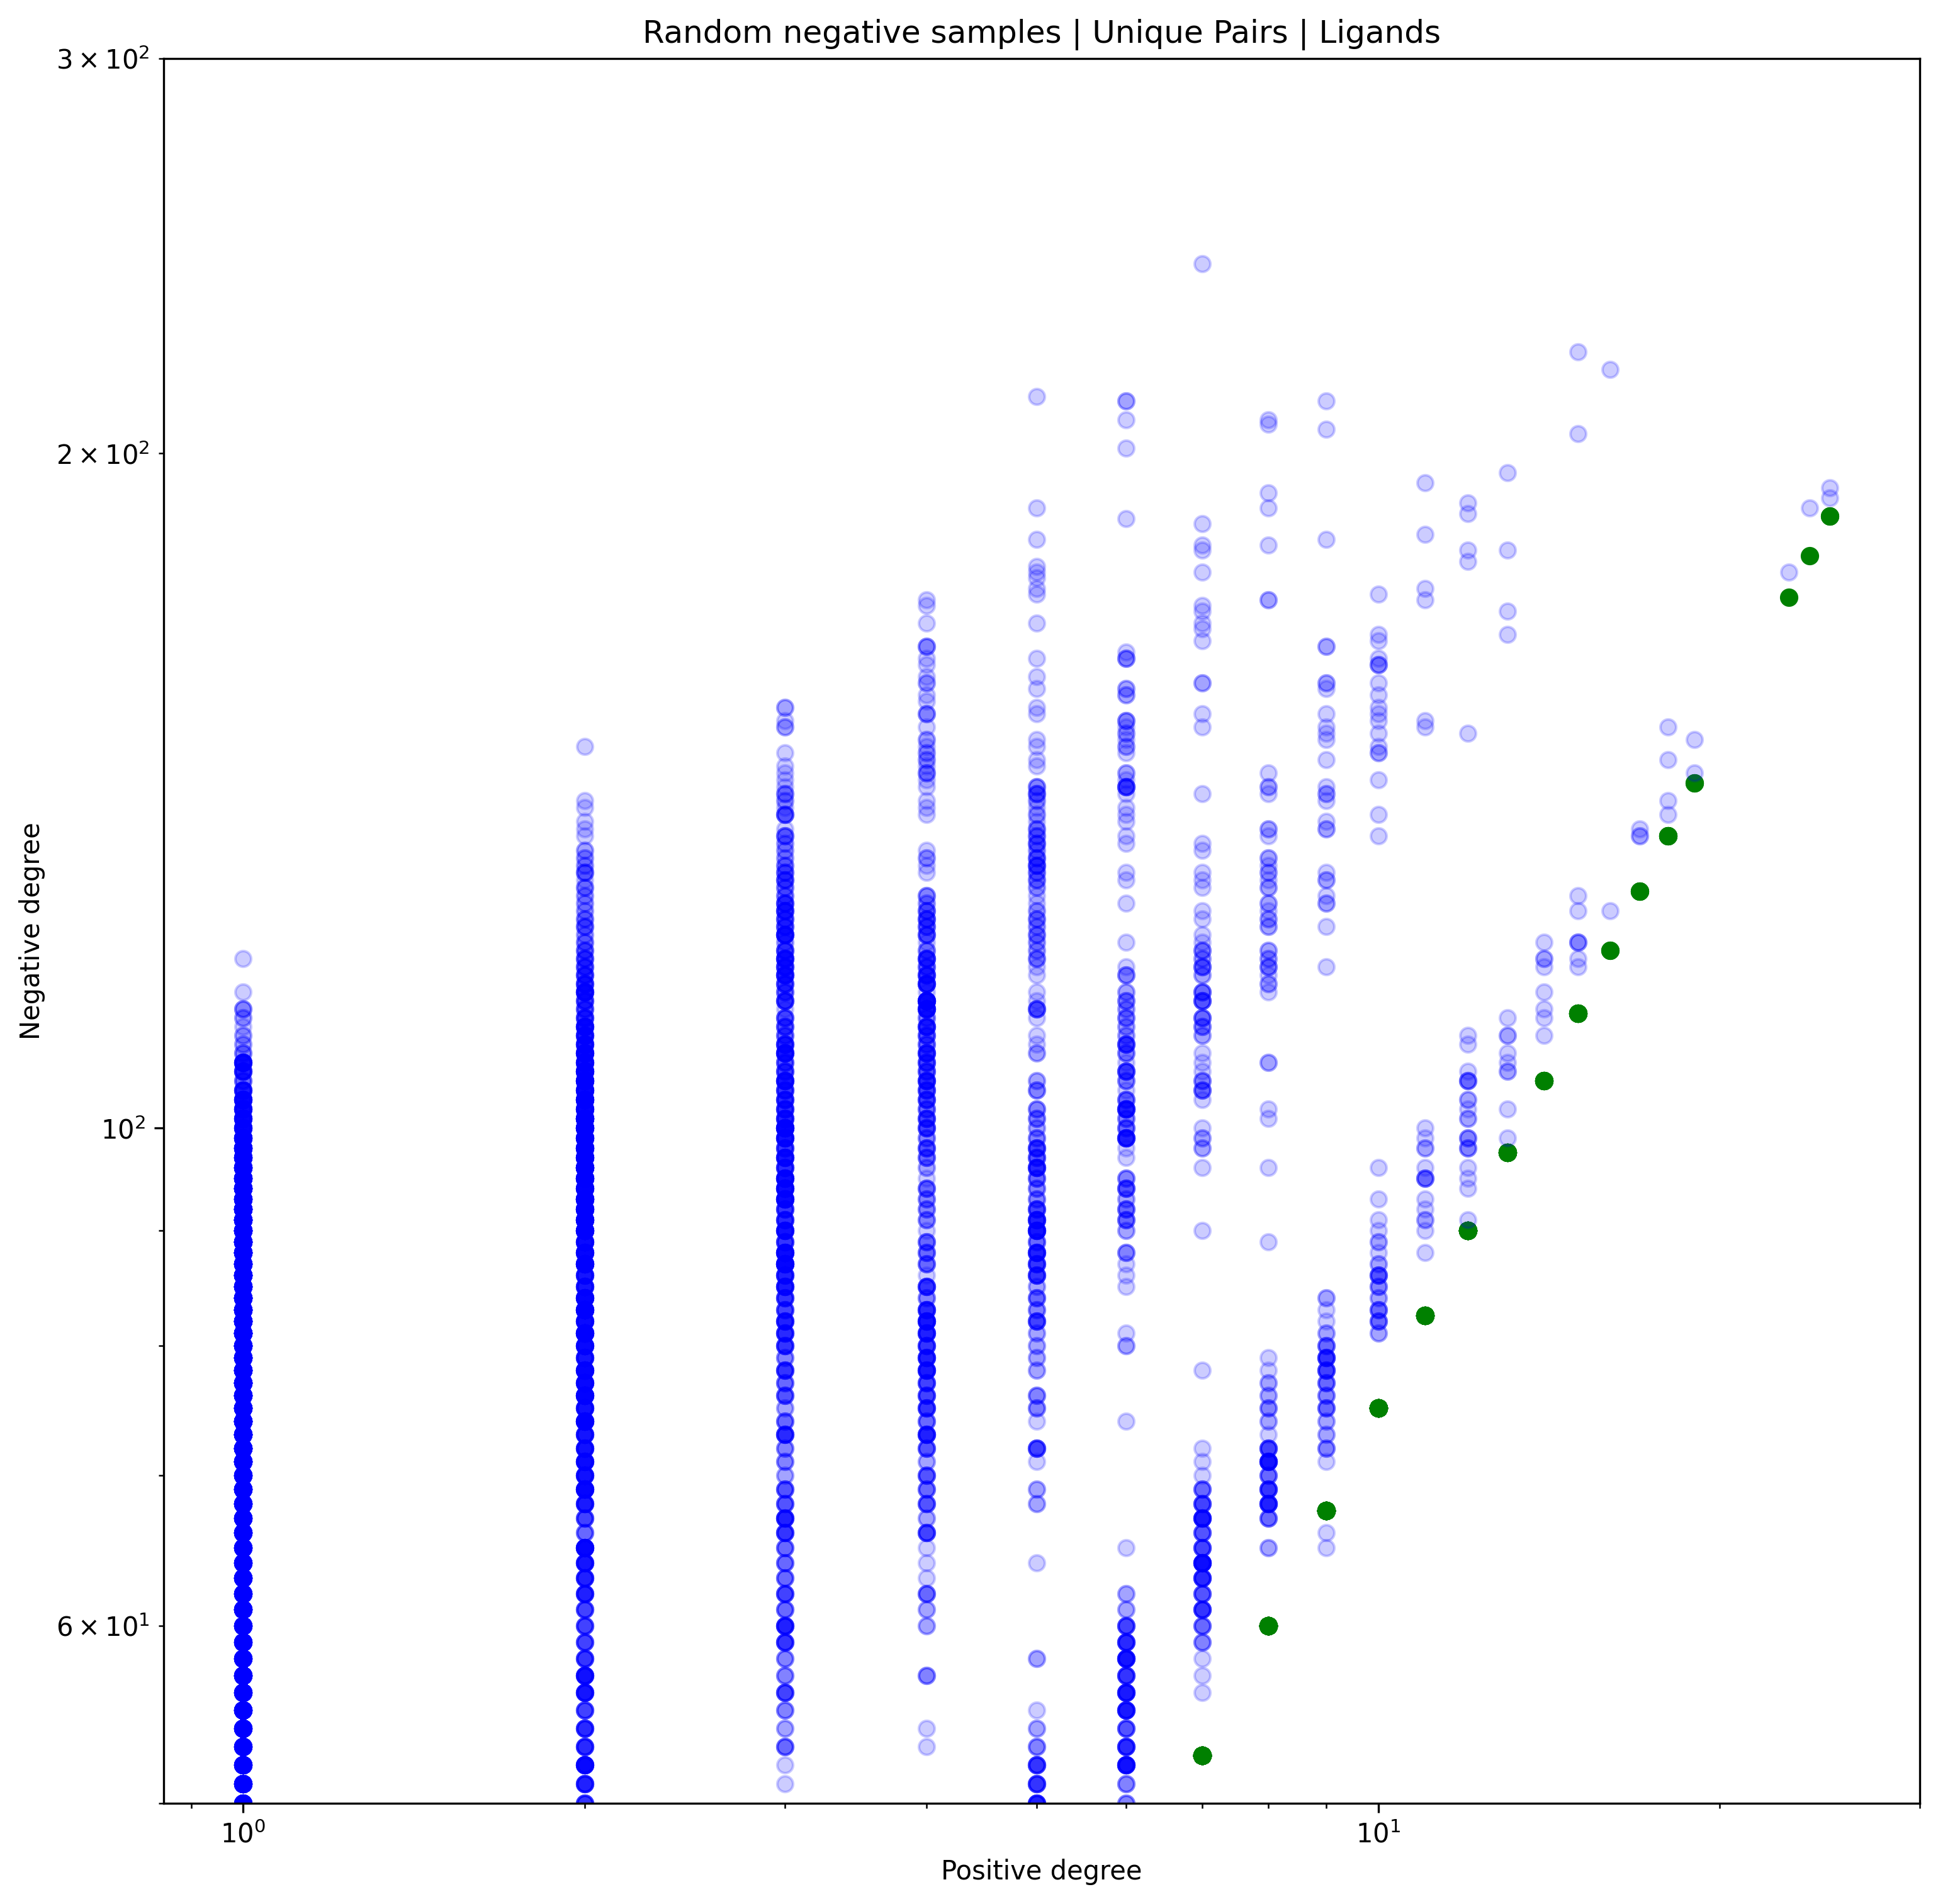

In [26]:
plt.figure(figsize=(12, 12), dpi=300)
plt.scatter(pos_deg_list_unique,[7.5*x for x in pos_deg_list_unique],color='green')
plt.scatter(pos_deg_list_unique,neg_deg_list_unique,alpha=0.2,color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0,30])
plt.ylim([50,300])
plt.xlabel('Positive degree')
plt.ylabel('Negative degree')
plt.title('Random negative samples | Unique Pairs | Ligands')
plt.savefig("SI17a.svg", format="svg")

In [27]:
df = pd.DataFrame()
df['Positive_degree'] = pos_deg_list_unique
df['Expected_negative_degree'] = [7.5*x for x in pos_deg_list_unique]
df['Negative_degree'] = neg_deg_list_unique
df.to_csv('SI17a.csv') 

In [28]:
train_pos_unique = train_unique[train_unique['Y'] == 1]
train_neg_unique = train_unique[train_unique['Y'] == 0]

unique_targets = set(train_unique['target_aa_code'].tolist())

pos_deg_list_unique_targets = []
neg_deg_list_unique_targets = []

for target_name in tqdm(unique_targets):
    subdf_pos_unique = train_pos_unique[train_pos_unique['target_aa_code'] == target_name]
    pos_deg_list_unique_targets.append(len(subdf_pos_unique))
    subdf_neg_unique = train_neg_unique[train_neg_unique['target_aa_code'] == target_name]
    neg_deg_list_unique_targets.append(len(subdf_neg_unique))


  0%|          | 0/5104 [00:00<?, ?it/s]

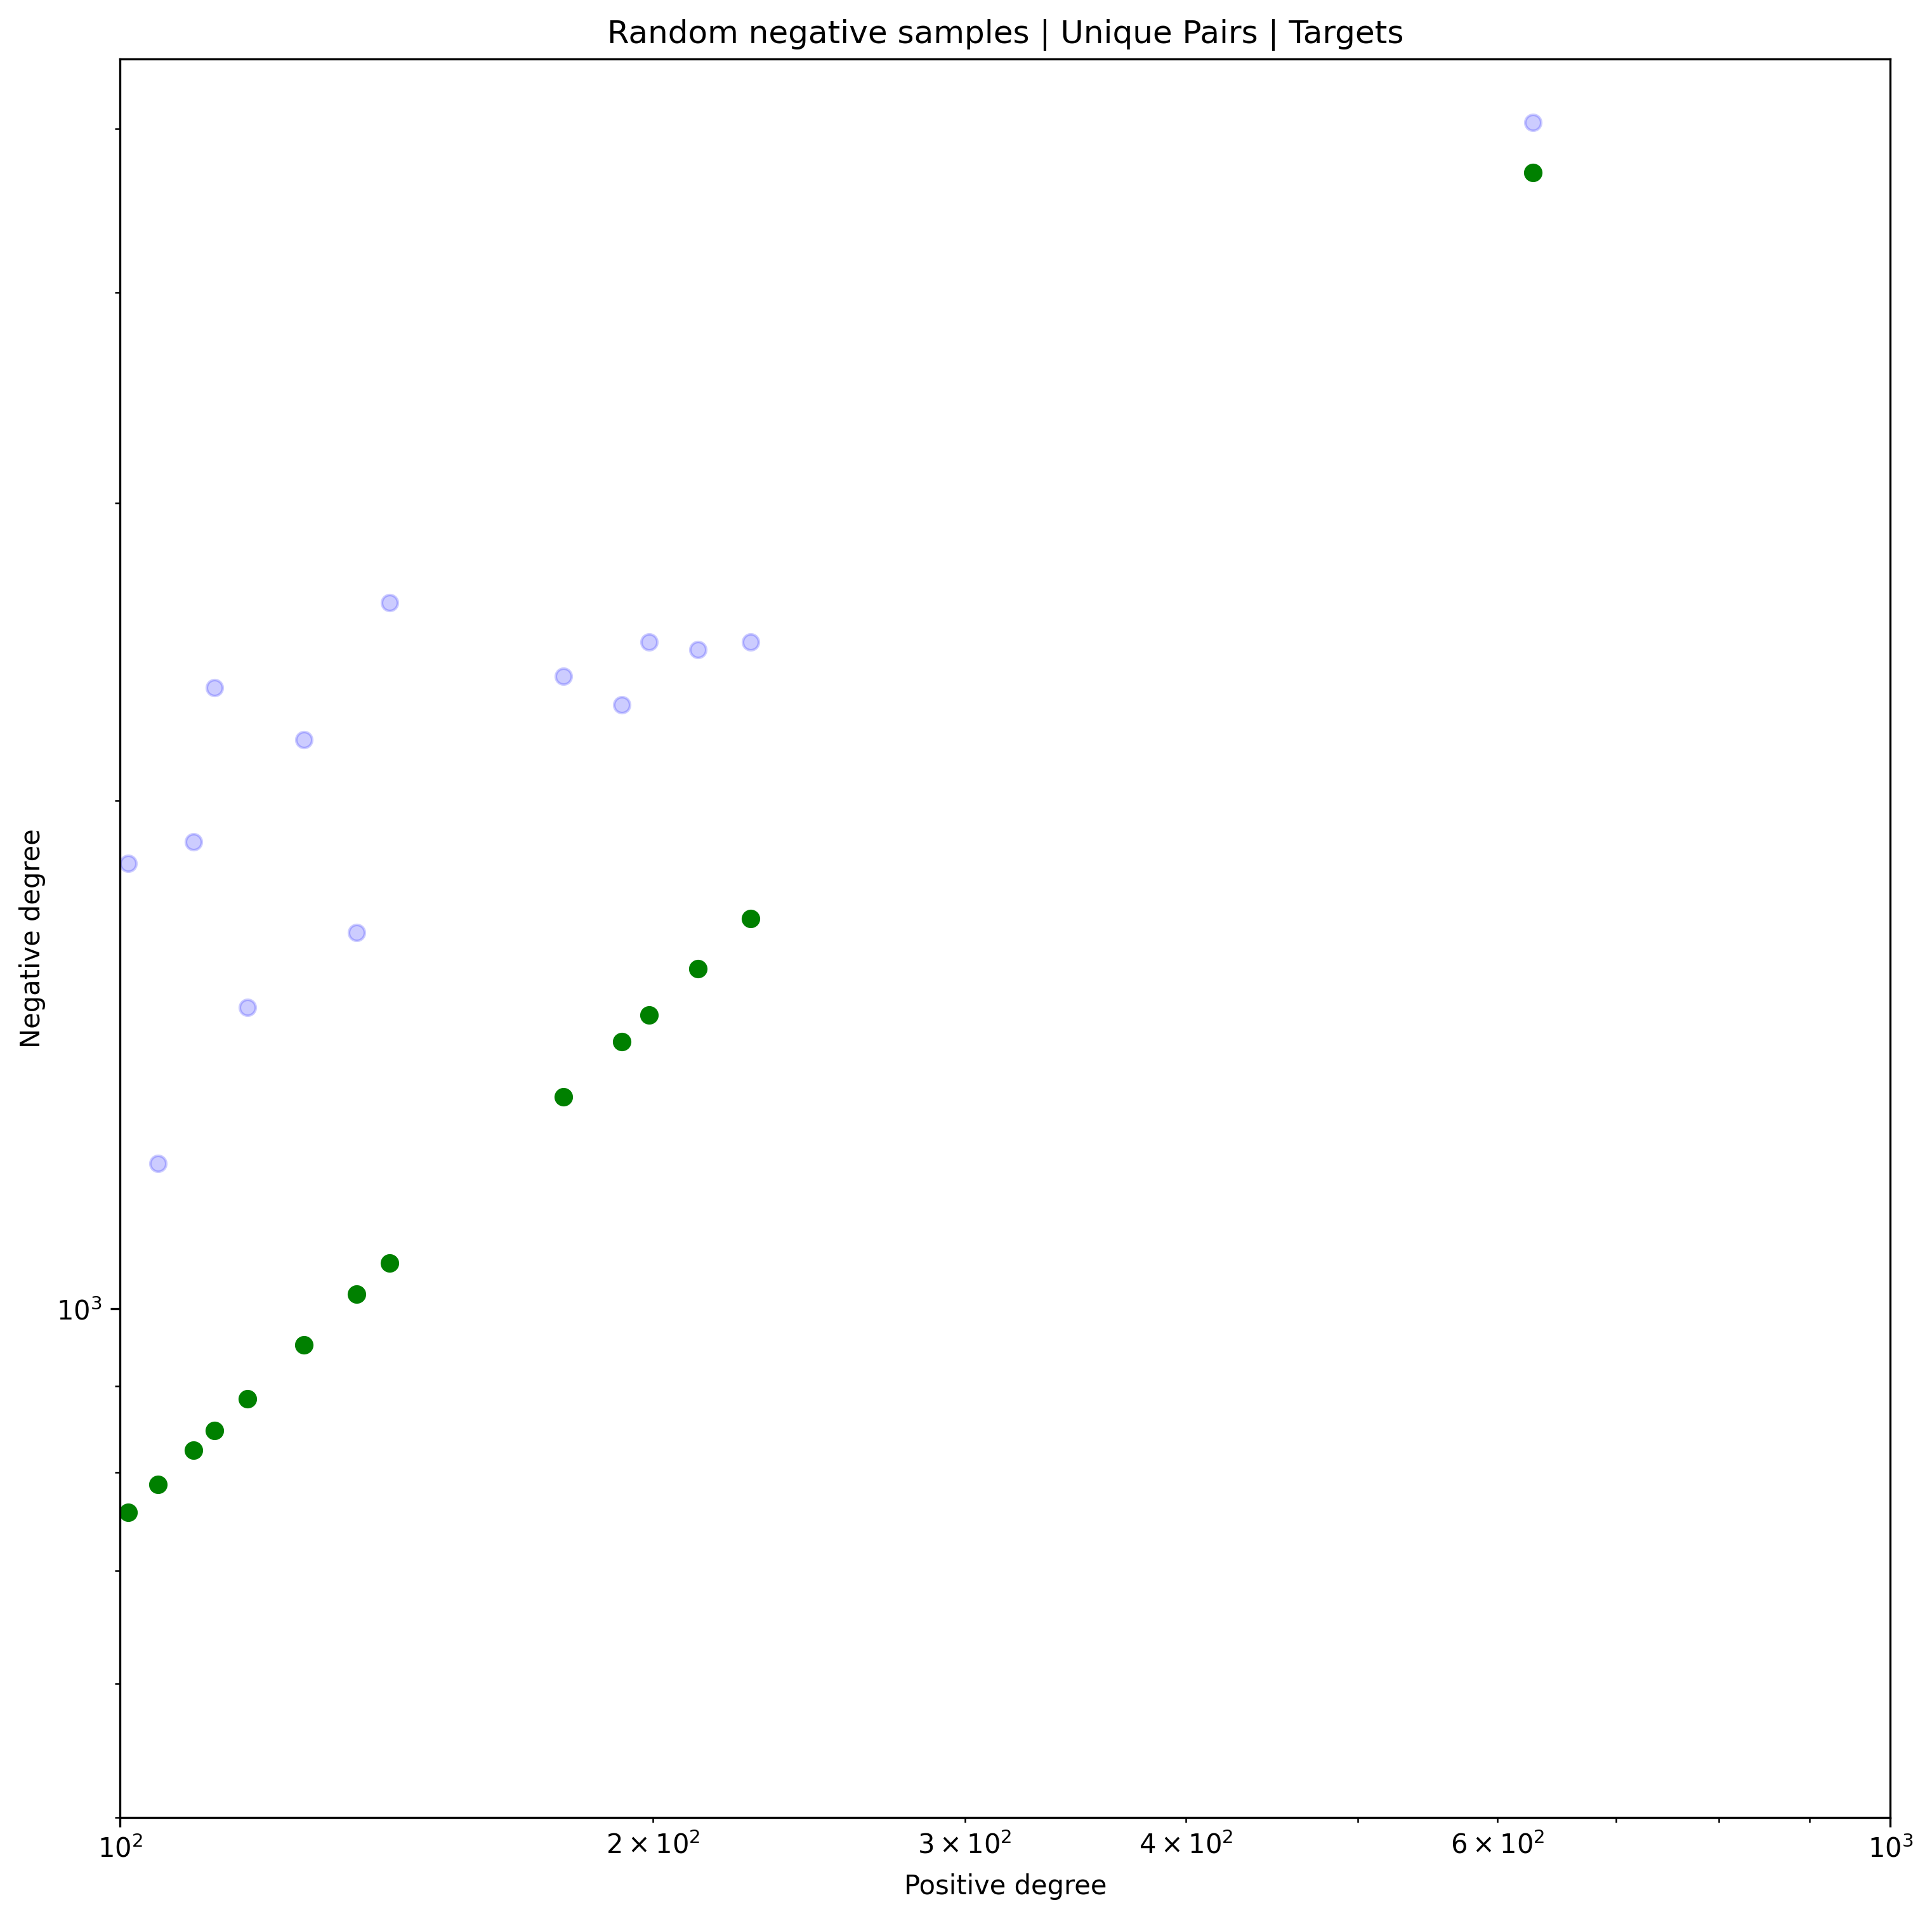

In [29]:
plt.figure(figsize=(12, 12), dpi=300)
plt.scatter(pos_deg_list_unique_targets,[7.5*x for x in pos_deg_list_unique_targets],color='green')
plt.scatter(pos_deg_list_unique_targets,neg_deg_list_unique_targets,alpha=0.2,color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlim([100,1000])
plt.ylim([500,5500])
plt.xlabel('Positive degree')
plt.ylabel('Negative degree')
plt.title('Random negative samples | Unique Pairs | Targets')
plt.savefig("SI17b.svg", format="svg")

In [30]:
df = pd.DataFrame()
df['Positive_degree'] = pos_deg_list_unique_targets
df['Expected_negative_degree'] = [7.5*x for x in pos_deg_list_unique_targets]
df['Negative_degree'] = neg_deg_list_unique_targets
df.to_csv('SI17b.csv') 

In [31]:
len(train)

628000

In [32]:
len(train_unique)

580612

In [33]:
print('Ligands | Rank correlation between the number of positive and negative annotations: ')
# print('Random negative - all pairs: ', stats.spearmanr(pos_deg_list,neg_deg_list))
print('Random negative - unique pairs: ', stats.spearmanr(pos_deg_list_unique,neg_deg_list_unique))

Ligands | Rank correlation between the number of positive and negative annotations: 
Random negative - unique pairs:  SpearmanrResult(correlation=0.3864608056324081, pvalue=1.3247377214206748e-252)


In [34]:
print('Targets | Rank correlation between the number of positive and negative annotations: ')
# print('Random negative - all pairs: ', stats.spearmanr(pos_deg_list,neg_deg_list))
print('Random negative - unique pairs: ', stats.spearmanr(pos_deg_list_unique_targets,neg_deg_list_unique_targets))

Targets | Rank correlation between the number of positive and negative annotations: 
Random negative - unique pairs:  SpearmanrResult(correlation=0.8696802005454504, pvalue=0.0)


# Network negative samples

In [35]:
network_negatives = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_2_filtered.csv')

In [36]:
network_negatives_unique = network_negatives.drop_duplicates(subset=['InChiKey','target_aa_code'])

In [37]:
len(network_negatives)

82589

In [38]:
len(network_negatives_unique)

79710

In [39]:
network_negatives_unique_pos = network_negatives_unique[network_negatives_unique['Y'] == 1]
network_negatives_unique_neg = network_negatives_unique[network_negatives_unique['Y'] == 0]

unique_ligands = set(network_negatives_unique['InChiKey'].tolist())

pos_deg_list_network_negatives_unique = []
neg_deg_list_network_negatives_unique = []

for ligand_name in tqdm(unique_ligands):
    subdf_pos_unique = network_negatives_unique_pos[network_negatives_unique_pos['InChiKey'] == ligand_name]
    pos_deg_list_network_negatives_unique.append(len(subdf_pos_unique))
    subdf_neg_unique = network_negatives_unique_neg[network_negatives_unique_neg['InChiKey'] == ligand_name]
    neg_deg_list_network_negatives_unique.append(len(subdf_neg_unique))


  0%|          | 0/6792 [00:00<?, ?it/s]

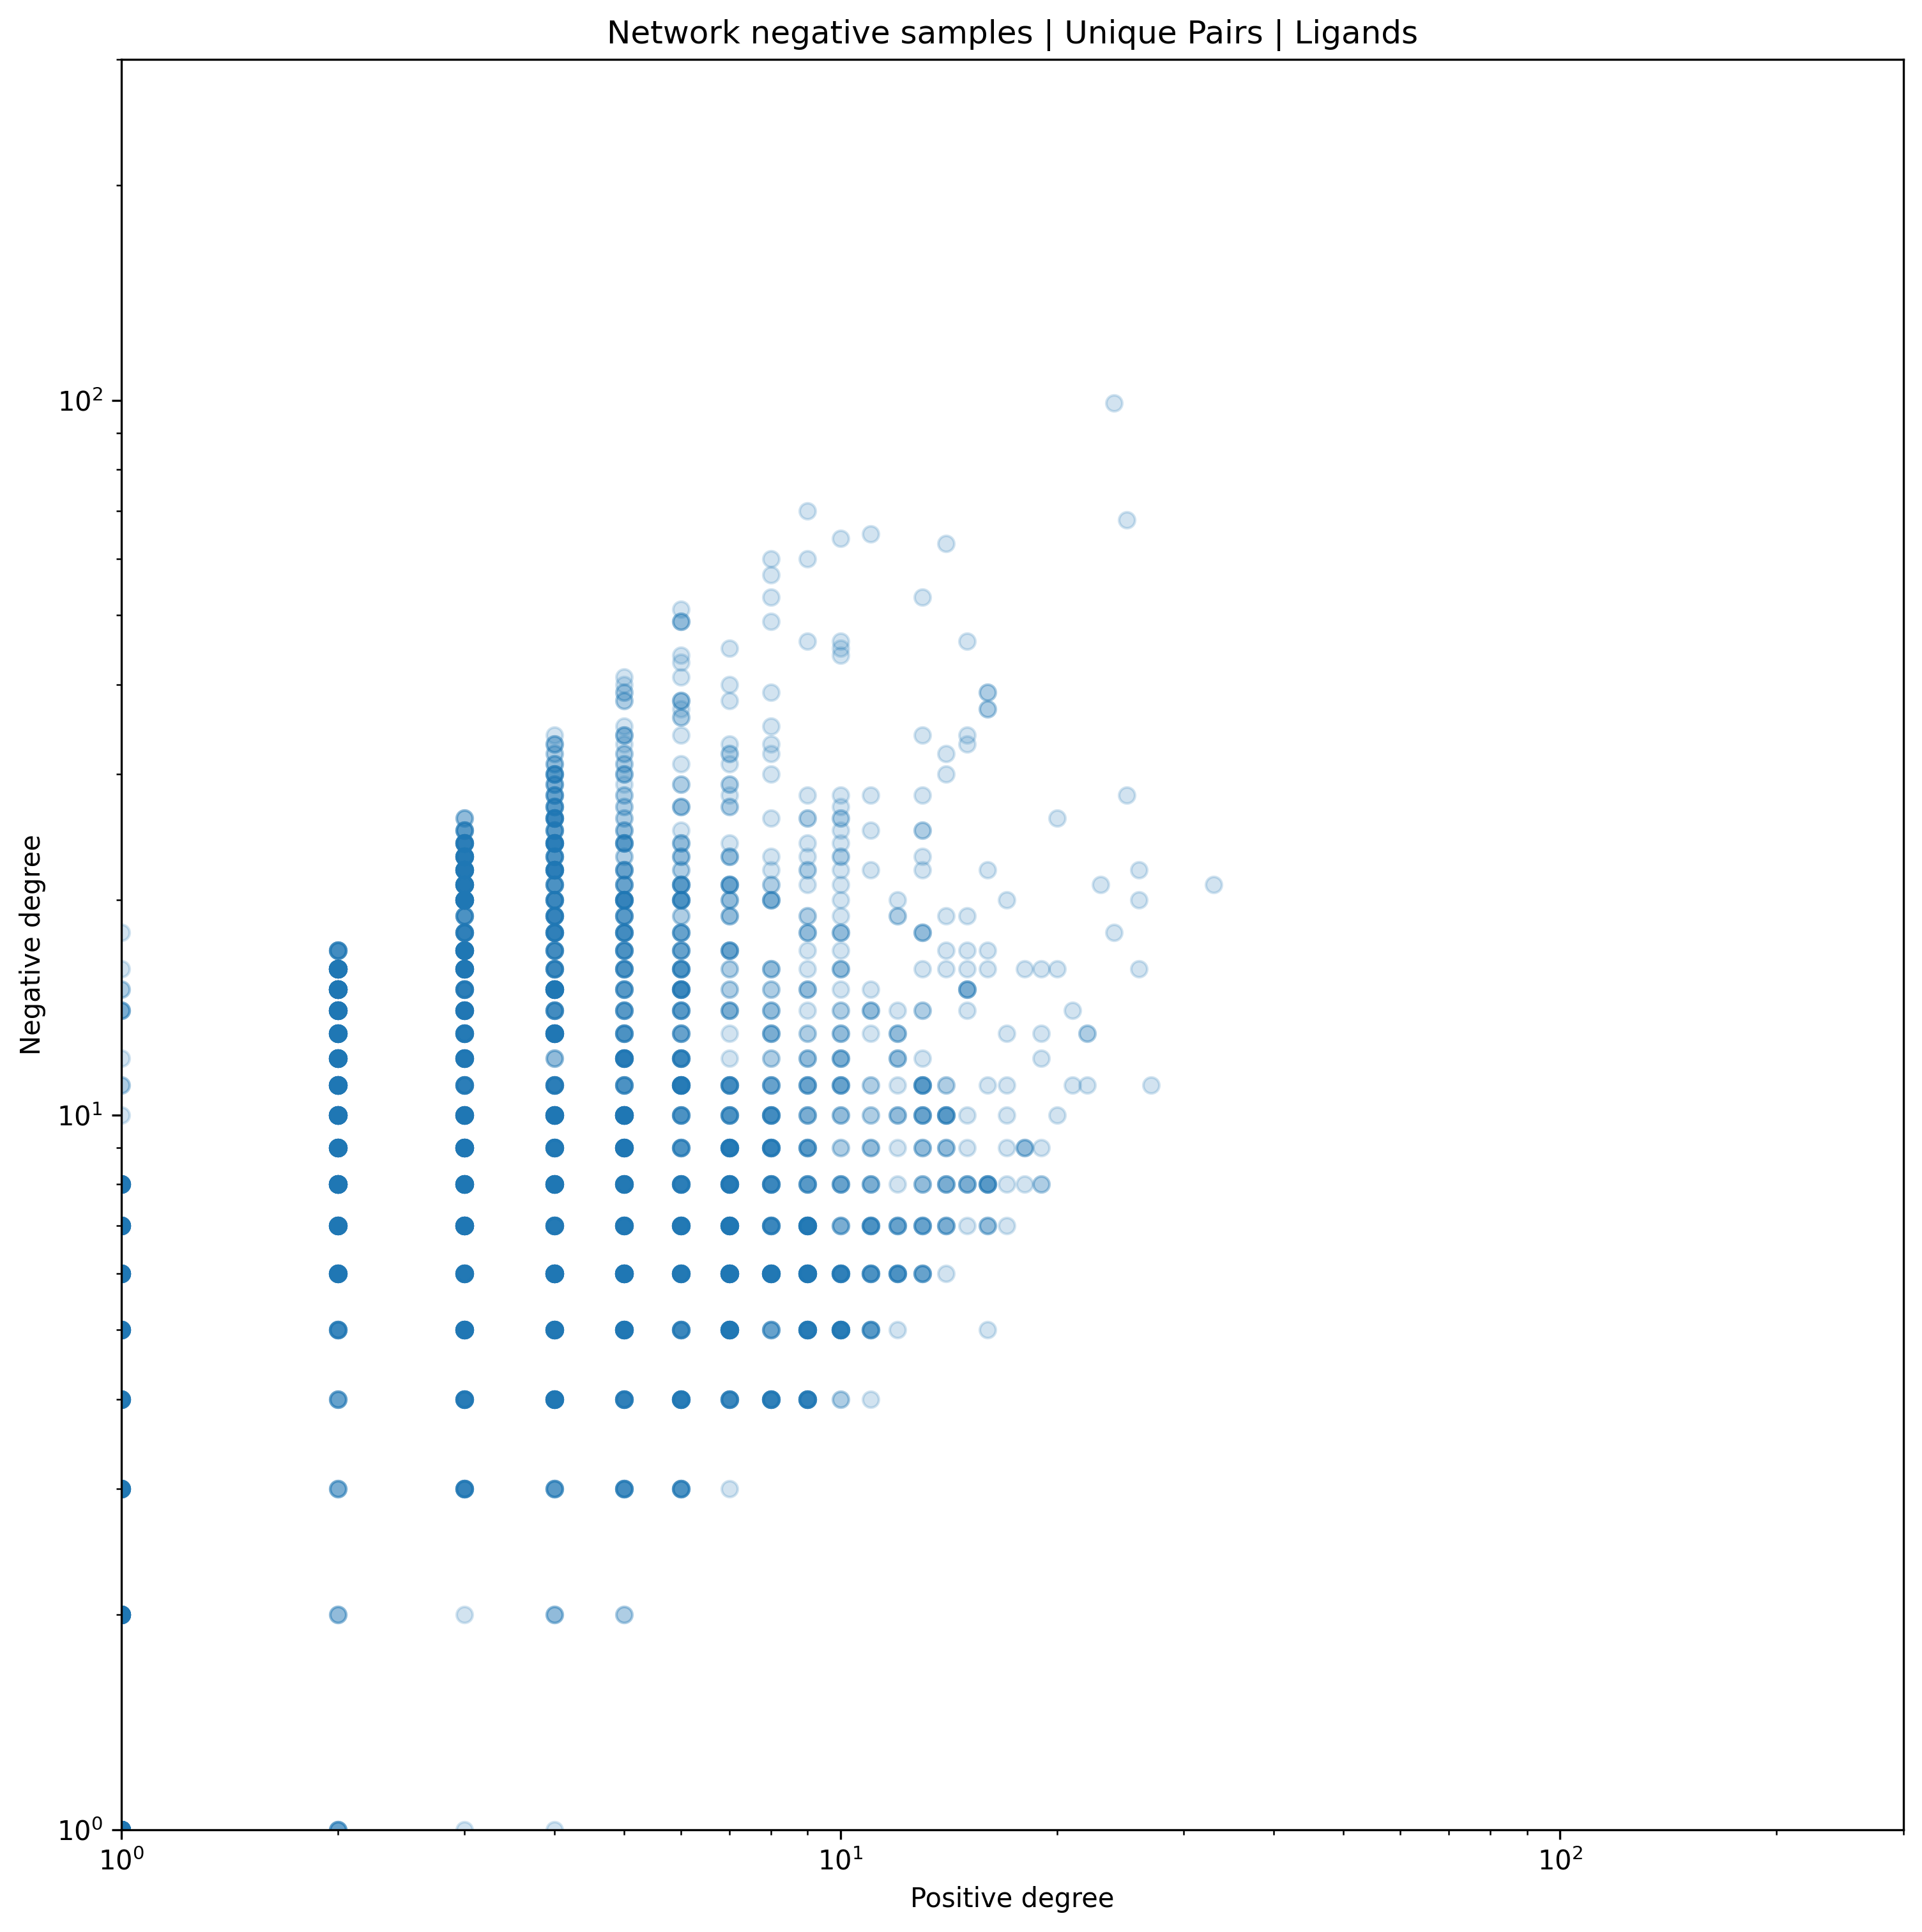

In [41]:
plt.figure(figsize=(12, 12), dpi=300)
plt.scatter(pos_deg_list_network_negatives_unique,neg_deg_list_network_negatives_unique,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,300])
plt.ylim([1,300])
plt.xlabel('Positive degree')
plt.ylabel('Negative degree')
plt.title('Network negative samples | Unique Pairs | Ligands')
plt.savefig("SI17c.svg", format="svg")

In [40]:
df = pd.DataFrame()
df['Positive_degree'] = pos_deg_list_network_negatives_unique
df['Negative_degree'] = neg_deg_list_network_negatives_unique
df.to_csv('SI17c.csv') 

In [42]:
print('Ligands | Rank correlation between the number of positive and negative annotations: ')
# print('Network negative - all pairs: ', stats.spearmanr(pos_deg_list_network_negatives,neg_deg_list_network_negatives))
print('Network negative - unique pairs: ', stats.spearmanr(pos_deg_list_network_negatives_unique,neg_deg_list_network_negatives_unique))

Ligands | Rank correlation between the number of positive and negative annotations: 
Network negative - unique pairs:  SpearmanrResult(correlation=0.32888928406852175, pvalue=4.776464489024824e-171)


In [43]:
network_negatives_unique_pos = network_negatives_unique[network_negatives_unique['Y'] == 1]
network_negatives_unique_neg = network_negatives_unique[network_negatives_unique['Y'] == 0]

unique_targets = set(network_negatives_unique['target_aa_code'].tolist())

pos_deg_list_network_negatives_unique_targets = []
neg_deg_list_network_negatives_unique_targets = []

for target_name in tqdm(unique_targets):
    subdf_pos_unique_targets = network_negatives_unique_pos[network_negatives_unique_pos['target_aa_code'] == target_name]
    pos_deg_list_network_negatives_unique_targets.append(len(subdf_pos_unique_targets))
    subdf_neg_unique_targets = network_negatives_unique_neg[network_negatives_unique_neg['target_aa_code'] == target_name]
    neg_deg_list_network_negatives_unique_targets.append(len(subdf_neg_unique_targets))


  0%|          | 0/3177 [00:00<?, ?it/s]

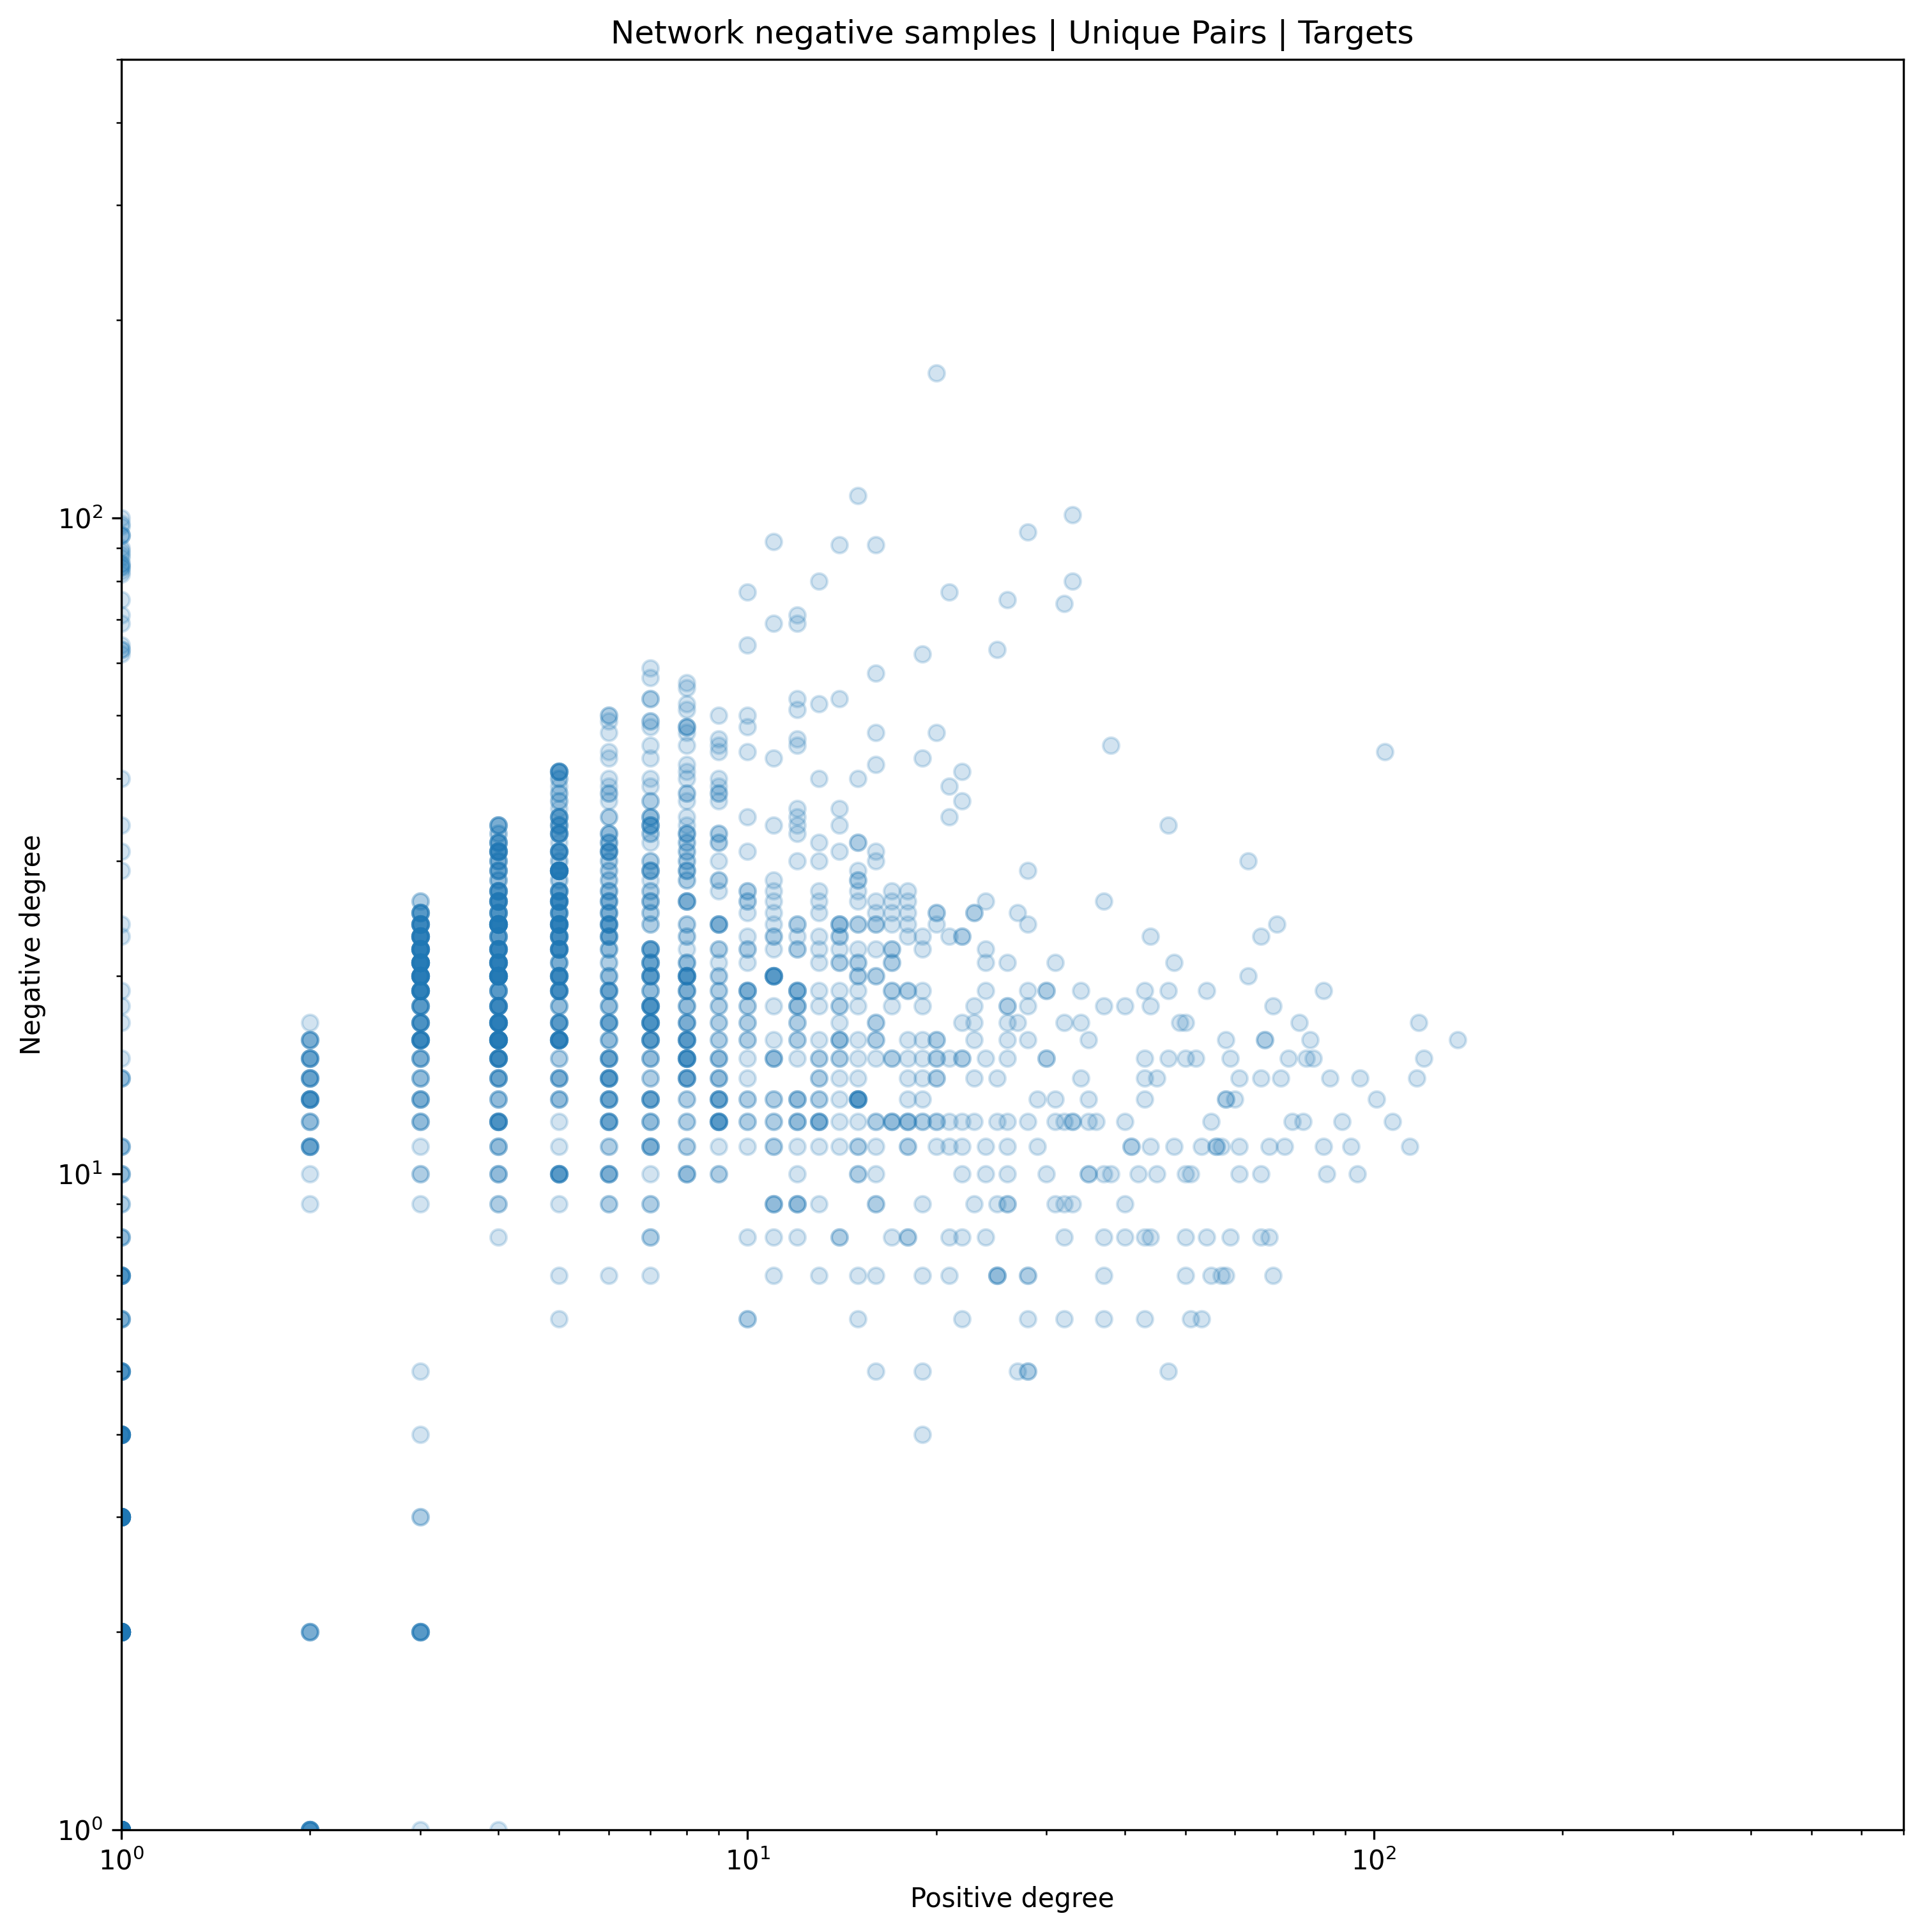

In [44]:
plt.figure(figsize=(12, 12), dpi=300)
plt.scatter(pos_deg_list_network_negatives_unique_targets,neg_deg_list_network_negatives_unique_targets,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,700])
plt.ylim([1,500])
plt.xlabel('Positive degree')
plt.ylabel('Negative degree')
plt.title('Network negative samples | Unique Pairs | Targets')
plt.savefig("SI17d.svg", format="svg")

In [45]:
df = pd.DataFrame()
df['Positive_degree'] = pos_deg_list_network_negatives_unique_targets
df['Negative_degree'] = neg_deg_list_network_negatives_unique_targets
df.to_csv('SI17d.csv') 

In [46]:
print('Targets | Rank correlation between the number of positive and negative annotations: ')
# print('Network negative - all pairs: ', stats.spearmanr(pos_deg_list_network_negatives,neg_deg_list_network_negatives))
print('Network negative - unique pairs: ', stats.spearmanr(pos_deg_list_network_negatives_unique_targets,neg_deg_list_network_negatives_unique_targets))

Targets | Rank correlation between the number of positive and negative annotations: 
Network negative - unique pairs:  SpearmanrResult(correlation=0.3846899329122209, pvalue=1.4094393486401548e-112)
